# Evaluation of the model

In [223]:
import os
import csv
import pickle
import numpy as np
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import random
import datetime
import scipy.stats as sp 
from matplotlib import cm
import imageio

In [2]:
log_dir = "./log" 
FIGSIZE = (15,9)
LW = 3
plt.rcParams.update({'font.size': 22})

In [385]:
def plot_performance(means,stds,X=None,names=None,title="",ylabel="performance", minimum = -np.inf, maximum=np.inf,
                     log=False, double =False, xlabel="learning episodes"):
    if names is None:
        names = [str(j) for j in range(len(means))]
    compute_X = (X is None)
    if len(means)<6:
        ncol = [1,1,2,2,3][len(means)-1] 
    else:
        ncol = len(means)//2
    fig, ax = plt.subplots(figsize=FIGSIZE)
    colors = ['blueviolet','royalblue','crimson','darkgreen','orange']
    handles = []
    for i in range(len(means)):
        if (double and i>=len(means)/2):
            linestyle = ":"
            color = colors[i%(len(means)//2)]
        else:
            linestyle = "-"
            color = colors[i%len(colors)]
        
        mean, std = np.array(means[i]), np.array(stds[i])
        mean_p_std = np.minimum(mean+std, maximum)
        mean_m_std = np.maximum(mean-std, minimum)
        
        if compute_X:
            X = [x for x in range(len(mean))]
        plt.plot(X,mean, color = color,lw=LW, linestyle=linestyle)
        ax.fill_between(X,mean_p_std , mean_m_std, color= color, alpha=0.15)
        plt.plot(X, mean_p_std, color=color, alpha=0.2)
        plt.plot(X, mean_m_std, color=color, alpha=0.2)
        handles.append( mlines.Line2D([], [], color = color, linestyle=linestyle, label= names[i]))
    if log:
        plt.yscale("log")
        if (X[1]-X[0])!=(X[-1]-X[-2]):
            plt.xscale("log")
    else:
        if minimum != -np.inf and maximum!=np.inf:
            plt.ylim(minimum,maximum)
        elif minimum != -np.inf:
            plt.ylim(minimum)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(handles=handles, numpoints = 2,ncol=1,bbox_to_anchor=(1.01, 1.))
    plt.show()

## One model Many runs

In [493]:
def compute_bins(obs, objx, objy, bounds):
    n_bins = [20,20]
    N_bins = n_bins[0]*n_bins[1]
    x , y = obs[:,objx],obs[:,objy]
    bins = sp.binned_statistic_2d(x, y, None, 'count', bins=n_bins, range=bounds).binnumber
    return len(set(bins))/N_bins 

objects_param = [(3,4,[[-1., 1.], [-1., 1.]]), (8,9,[[-1.5, 1.5], [-1.5, 1.5]]), 
    (12,13,[[-1.5, 1.5], [-1.5, 1.5]]), (14,15,[[-1.5, 1.5], [-1.5, 1.5]]),(16,17,[[-1.5, 1.5], [-1.5, 1.5]])]

def plt_2_rgb(ax):
    ax.figure.canvas.draw()
    data = np.frombuffer(ax.figure.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(ax.figure.canvas.get_width_height()[::-1] + (3,))
    return data

def plot_coverage(subdirs, data_type, iterations, n_cpus=None ):
    subdir = subdirs[0]
    images = []
    for iteration in range(iterations):
        observations = np.zeros((0,18))
        for cpu in range(n_cpus):
            filename = 'final_observations_r'+str(cpu)+'_'+str(iteration)+'.pk'
            with open(subdir+"/"+filename, 'br') as f:
                observation = pickle.load(f)
            observations = np.concatenate((observations,observation))
        
        fig,ax = plt.subplots(1,1, sharex=True,figsize=(14,14))
        colors = ['blueviolet','royalblue','crimson','darkgreen','orange']
        plt.scatter(observations[:,3],observations[:,4], c=colors[0], label = "Hand")
        plt.scatter(observations[:,8],observations[:,9], c=colors[1], label = "Left Stick")
        plt.scatter(observations[:,12],observations[:,13], c=colors[2], label = "Right Stick")
        plt.scatter(observations[:,14],observations[:,15], c=colors[3], label = "Magnet")
        plt.scatter(observations[:,16],observations[:,17], c=colors[4], label = "Scratch")
        plt.legend(loc=4)
        plt.ylim((-1.51,1.51))
        plt.xlim((-1.51,1.51))
        plt.title("Evaluation coverage "+str(iteration))
        images.append(plt_2_rgb(ax))
        plt.close()
    imageio.mimsave(subdir+'/coverage.gif', images, duration=0.5)
    
def compute_coverage(subdirs, data_type, iterations, n_cpus=None, plot=True ):
    subdir = subdirs[0]
    coverage_mean, coverage_std = [], []
    for iteration in range(iterations):
        coverage = [[] for _ in range(5)]
        for cpu in range(n_cpus):
            filename = 'final_observations_r'+str(cpu)+'_'+str(iteration)+'.pk'
            with open(subdir+"/"+filename, 'br') as f:
                observation = pickle.load(f)
            for obj in range(5):
                objx, objy, bounds = objects_param[obj]
                coverage[obj].append(compute_bins(observation, objx, objy, bounds))
        coverage_mean.append(np.mean(coverage,axis=1))
        coverage_std.append(np.std(coverage,axis=1))
    if plot:
        names = ['Hand', 'Left Stick', 'Right Stick', 'Magnet', 'Scratch']
        plot_performance(np.swapaxes(coverage_mean, 0,1), np.swapaxes(coverage_std, 0,1), 
                        names= names, minimum = 0, maximum=1, ylabel='coverage', xlabel='iterations',
                        title="Coverages")
    
    return coverage_mean, coverage_std

In [485]:
def confusion_matrix(subdirs, data_type, iterations, n_cpus=None, plot=True):
    def analyze_confusion_matrix(conf_matrix):
        [[TN,FN],[FP,TP]] = conf_matrix
        TPR = TP/(TP+FN) if (TP +FN) !=0 else 0
        TNR = TN/(TN+FP) if (FP +TN) !=0 else 0
        ACC = (TP+TN)/(TP+TN+FP+FN) if (TP+TN+FP+FN) !=0 else 0
        Precision = TP/(TP+FP) if (TP+FP) !=0 else 0
        FS = 2*TP/(2*TP+FP+FN) if (2*TP+FP+FN) !=0 else 0
        return [TPR,TNR,ACC,Precision,FS]
    
    tasks_group =[[0,1,2,3],
                  [4,6,7,8,9,26,14,27] , 
                  [5,10,11,12,13,28,15,29], 
                  [16,18,19,20,21],
                  [17,22, 23,24,25]]

    group_legend = ['Hand', 'Left Stick','Right Stick','Magnet', 'Scratch']

    rates_names = ['Recall','True Negative Rate','Accuracy','Precision','F1 Score']
    color = ['blueviolet','royalblue','crimson','darkgreen','orange']
        
    Rates = []
    Rates_error = []

    for it in range(iterations):
        
        rates_mean = []
        test = []
        for model in subdirs:
            if data_type == 1:
                for cpu in range(n_cpus):
                    filename = 'confusion_matrix_r'+str(cpu)+'_'+str(it)+'.pk'
                    with open(model+'/'+filename,'br')as f:
                        conf_matrix = pickle.load(f)
                    rates = [[] for _ in range(5)]
                    for group in tasks_group:
                        res = analyze_confusion_matrix(np.mean(conf_matrix[group],axis=0))
                        for i in range(5):
                            rates[i].append(res[i])
                    rates_mean.append(rates)
            else:
                filename = 'confusion_matrix_evaluation_data_'+str(it)+'.pk'
                with open(model+'/'+filename,'br')as f:
                    conf_matrix = pickle.load(f)
                for b in range(len(conf_matrix)):
                    rates = [[] for _ in range(5)]
                    for group in tasks_group:
                        res = analyze_confusion_matrix(np.mean(conf_matrix[b][group],axis=0))
                        for i in range(5):
                            rates[i].append(res[i])
                    rates_mean.append(rates)
        
        Rates.append(np.mean(rates_mean, axis=0))
        Rates_error.append(np.std(rates_mean, axis=0))
        
    Rates = np.array(Rates)
    Rates_error = np.array( Rates_error)
    F1score_mean = Rates[:,4]
    F1score_std = Rates_error[:,4]
        
    if plot:
        for rate in range(5):
            fig,ax = plt.subplots(1,1, sharex=True,figsize=(16,9))

            X = range(iterations)
            for g in range(5):
                mean_p_std = np.minimum(Rates[:,rate,g]+Rates_error[:,rate,g], 1)
                mean_m_std = np.maximum(Rates[:,rate,g]-Rates_error[:,rate,g], 0)
                plt.plot(Rates[:,rate,g], c=color[g], label=group_legend[g])
                ax.fill_between(X,mean_p_std, mean_m_std, color= color[g], alpha=0.15)
            plt.title(rates_names[rate])
            plt.legend()
            plt.ylim((0,1))
            
        plot_performance([F1score_mean], [F1score_std],
                        minimum=0, maximum=1, title="Rewards prediction", 
                        ylabel="F1 Score", xlabel="iterations")
    return F1score_mean, F1score_std

In [592]:
def regroup(data):
    """ data = [params, iterations, obs_dim=18] """
    hand  = np.mean(data[:,:,:6], axis=2)
    lstick  = np.mean(data[:,:,6:10], axis=2)
    rstick = np.mean(data[:,:,10:14], axis=2)
    magnet = np.mean(data[:,:,14:16], axis=2)
    scratch = np.mean(data[:,:,16:18], axis=2)
    return np.array([hand, lstick, rstick, magnet, scratch])

def prediction_errors(subdirs,func,data_type, iterations, n_cpus=None, plot=True):
    with open("/home/tim/Documents/stage-m2/tf_test/data/ArmToolsToy_1000pertinent.pk", 'br') as f:
        [true_traj,_] = pickle.load(f)
    true_traj = np.swapaxes(true_traj[:,:,:18], 0,1)
    null_model = np.mean(true_traj, axis=(0,1))
    N = np.sum((null_model-true_traj)**2, axis=(0,1))
    
    objects = ['Hand', 'Left Stick','Right Stick','Magnet', 'Scratch']
    
    traj_means, trans_means = [], []
    traj_stds, trans_stds = [], []
    R_traj_means, R_trans_means = [], []
    R_traj_stds, R_trans_stds = [], []
    
    for it in range(iterations):
        traj_errors, trans_errors, R_trans, R_traj = [], [], [], []
        for subdir in subdirs:

            if data_type == 1:
                for cpu in range(n_cpus):
                    data = 'prediction_r'+str(cpu)+'_'+str(it)+'.pk'
                    with open(subdir+'/'+data,'br')as f:
                        (pred_traj,pred_trans) = pickle.load(f)
                    pred_traj = pred_traj[:,:,:18]
                    E_trans = np.sum((pred_trans-true_traj)**2, axis=(0,1))
                    E_traj = np.sum((pred_traj-true_traj)**2, axis=(0,1))
                    traj_errors.append(np.mean((pred_traj-true_traj)**2, axis=(0,1)))
                    trans_errors.append(np.mean((pred_trans-true_traj)**2, axis=(0,1)))
                    R_trans.append(1-E_trans/N)
                    R_traj.append(1-E_traj/N)
            else:
                data = 'eval_evaluation_data_'+str(it)+'.pk'
                with open(subdir+'/'+data,'br')as f:
                    (pred_traj,pred_trans) = pickle.load(f)
                for b in range(len(pred_traj)):
                    pred_traj = pred_traj[b,:,:,:18]
                    pred_trans = pred_trans[b,:,:,:18]
                    E_trans = np.sum((pred_trans-true_traj)**2, axis=(0,1))
                    E_traj = np.sum((pred_traj-true_traj)**2, axis=(0,1))
                    traj_errors.append(E_traj**0.5)
                    trans_errors.append(E_trans**0.5)
                    R_trans.append(1-E_trans/N)
                    R_traj.append(1-E_traj/N)
        

        traj_means.append(np.mean(traj_errors, axis=0))
        trans_means.append(np.mean(trans_errors, axis=0))
        trans_stds.append(np.std(trans_errors, axis=0))
        traj_stds.append(np.std(traj_errors, axis=0))
        
        R_traj_means.append(np.mean(R_traj, axis=0))
        R_trans_means.append(np.mean(R_trans, axis=0))
        R_trans_stds.append(np.std(R_trans, axis=0))
        R_traj_stds.append(np.std(R_traj, axis=0))

    pred_means = regroup(np.array([traj_means]+[trans_means]))
    pred_stds =  regroup(np.array([traj_stds]+[trans_stds]))
    
    names = ['trajectory error',' transition error']
    if plot:
        for obj in range(5):
            plot_performance(pred_means[obj], pred_stds[obj],names=names, minimum=0, title="Error "+objects[obj], 
                         ylabel="Trajectory prediction error",xlabel="Iterations", log=True)
    
    R_means = regroup(np.array([R_traj_means]+[R_trans_means]))
    R_stds = regroup(np.array([R_traj_stds] +[R_trans_stds]))
    names = ['trajectory R²','transition R²']
    if plot:
        for obj in range(5):
            plot_performance(R_means[obj], R_stds[obj],names=names, minimum=0, maximum=1, 
                             ylabel="R²",xlabel="Iterations", title="R² "+objects[obj])
    return [[pred_means, pred_stds], [R_means, R_stds]]

In [568]:
model = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-14 16:25:08.634301"

models_4 = "/home/tim/Documents/stage-m2/multi-task-her-rl/src/data/ArmToolsToys-v1/third"
models_20 = "/home/tim/Documents/stage-m2/multi-task-her-rl/src/data/from_remote/test_armToolsToys_full"

subdirs = [models_4]
names = ["test"]

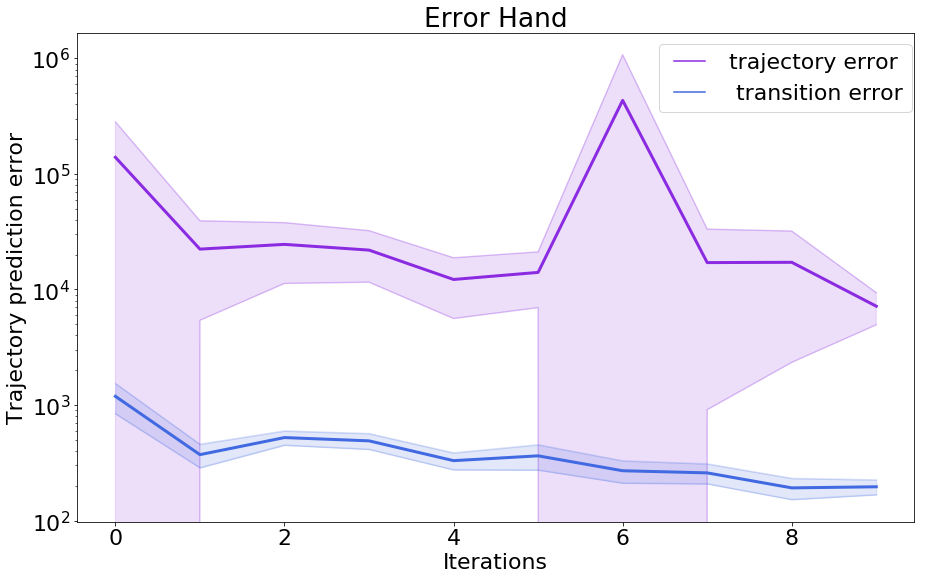

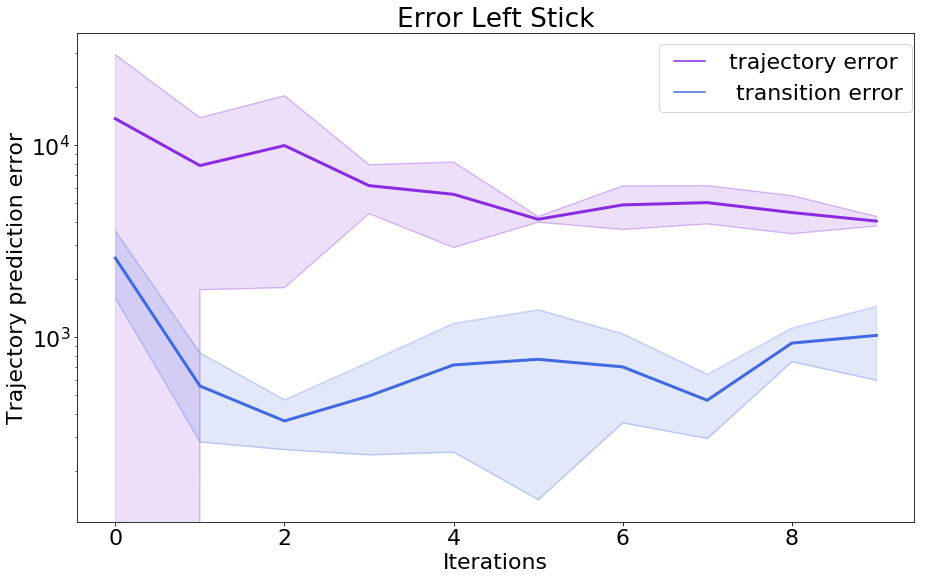

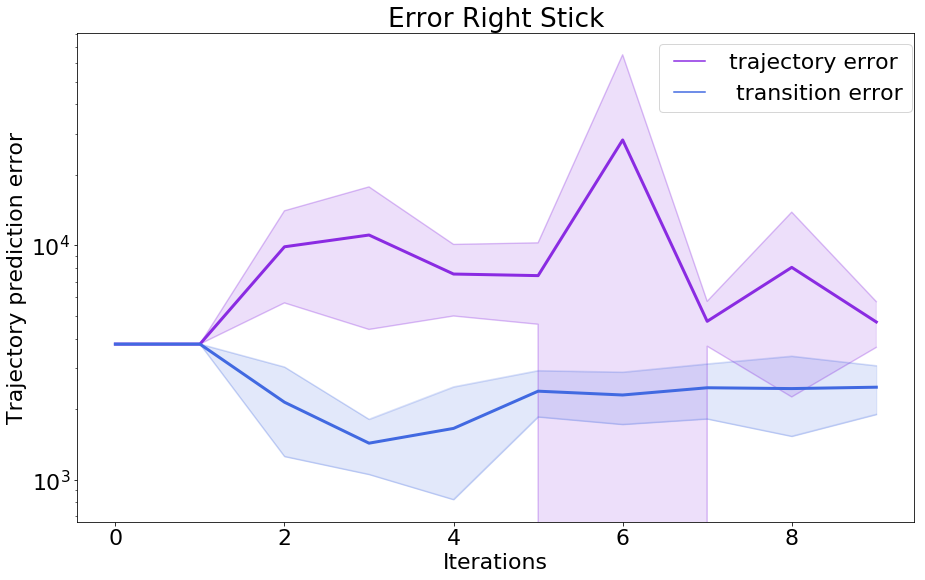

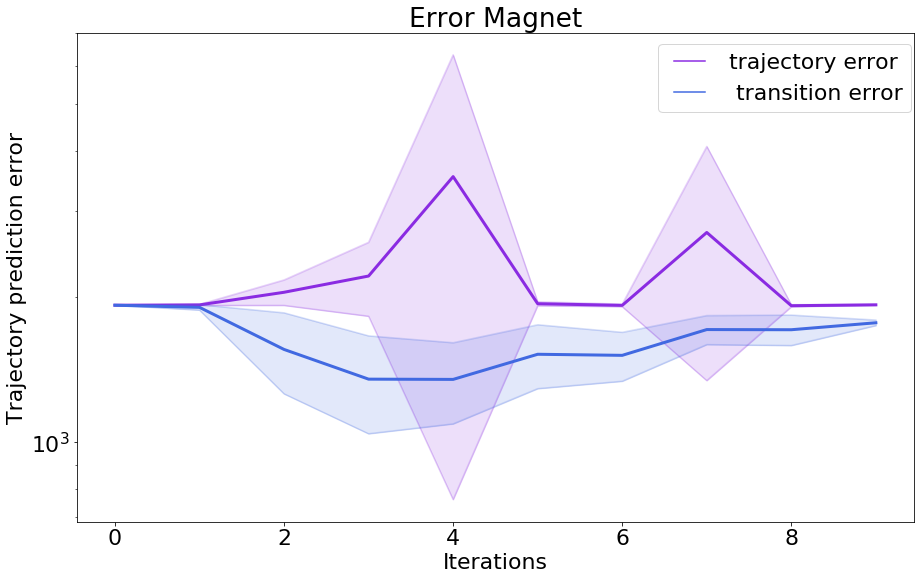

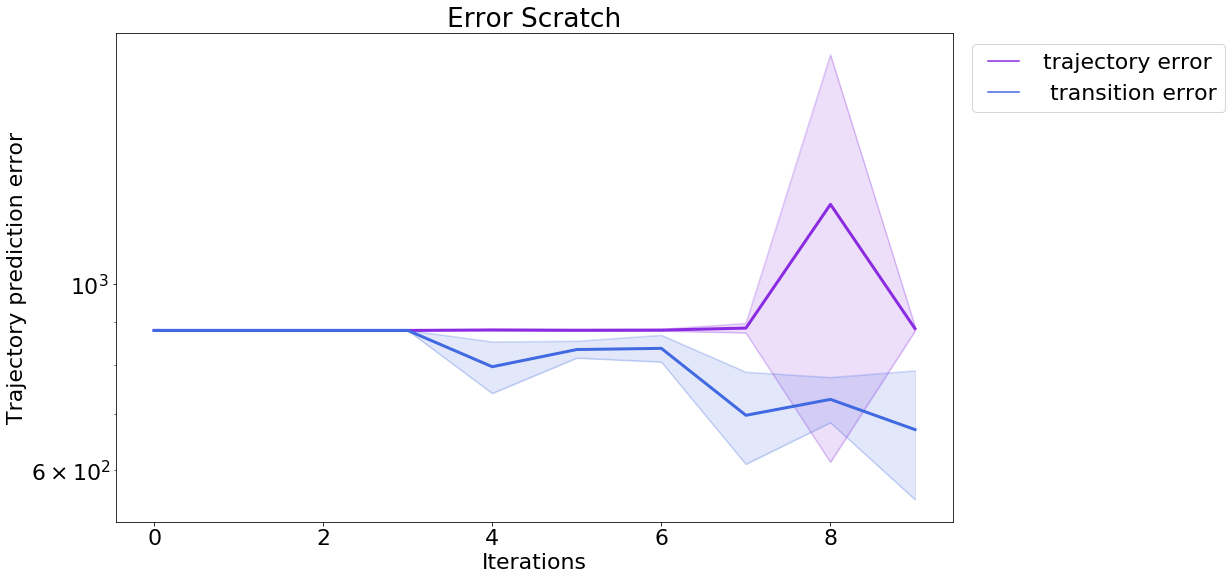

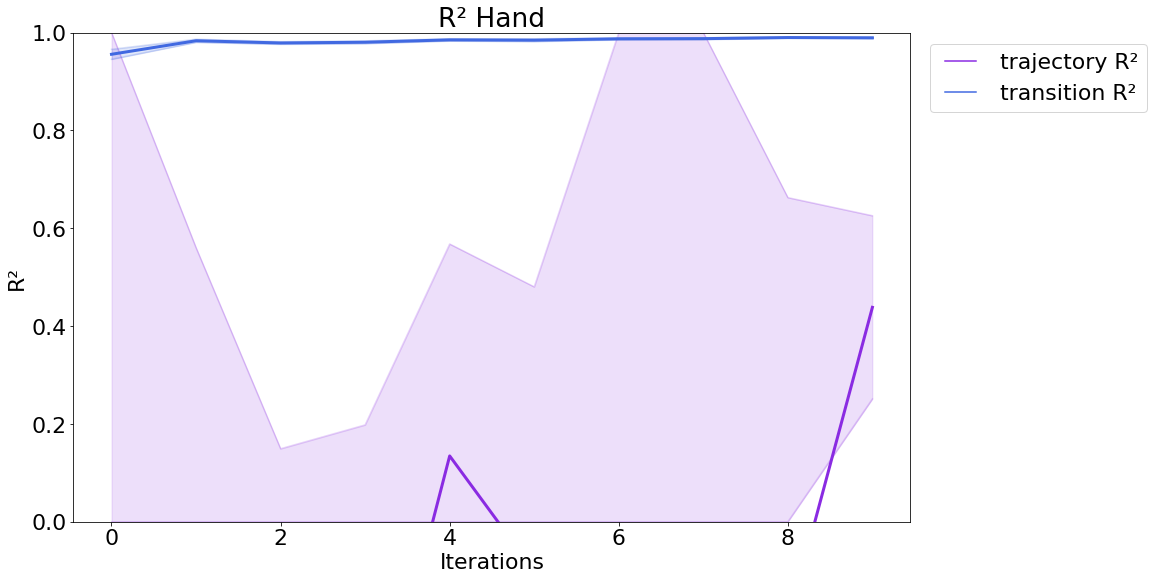

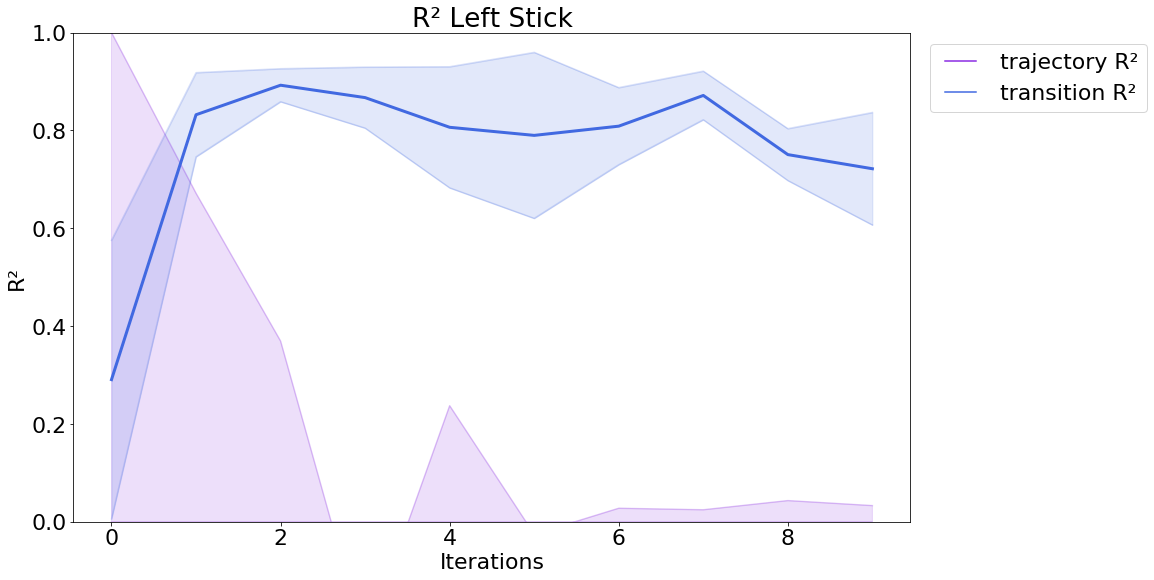

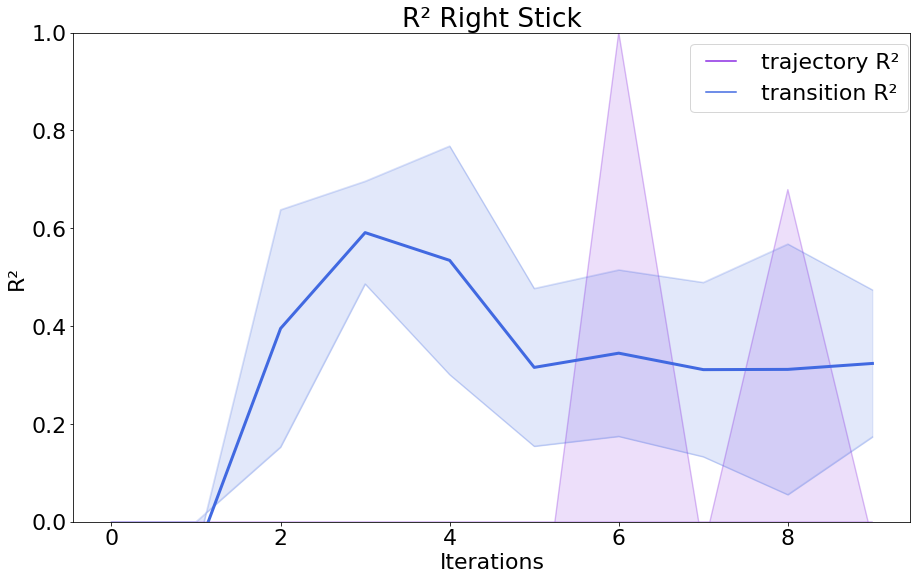

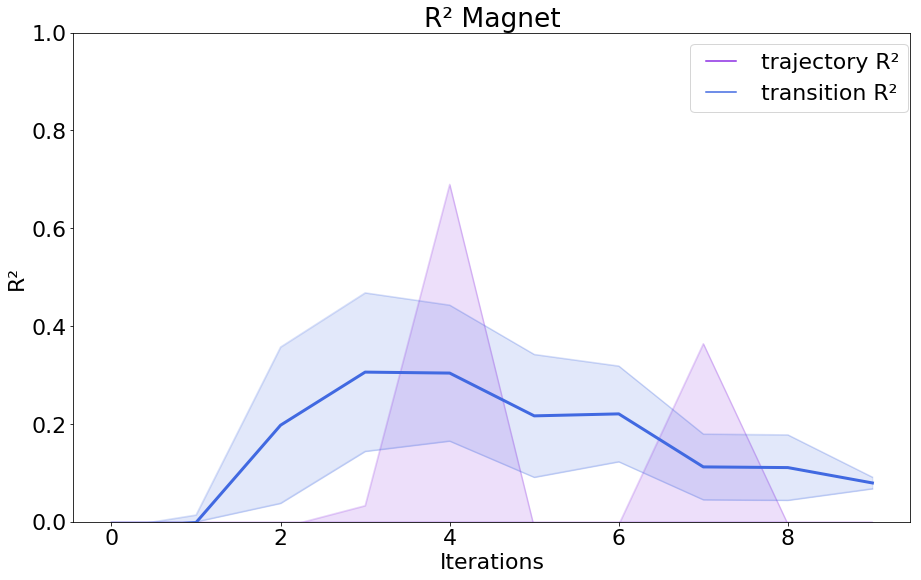

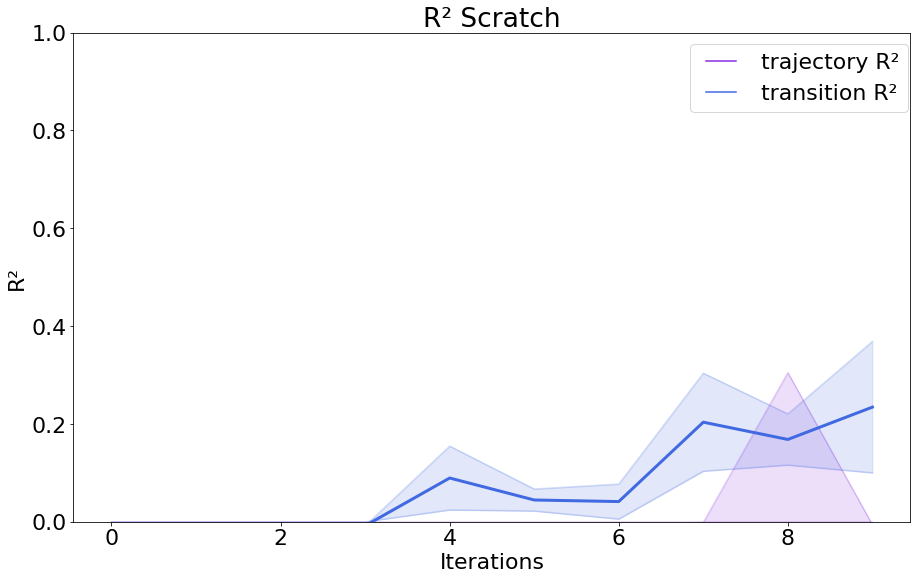

In [569]:
pred = prediction_errors(subdirs,np.mean,1,iterations=10, n_cpus=4, plot=True)

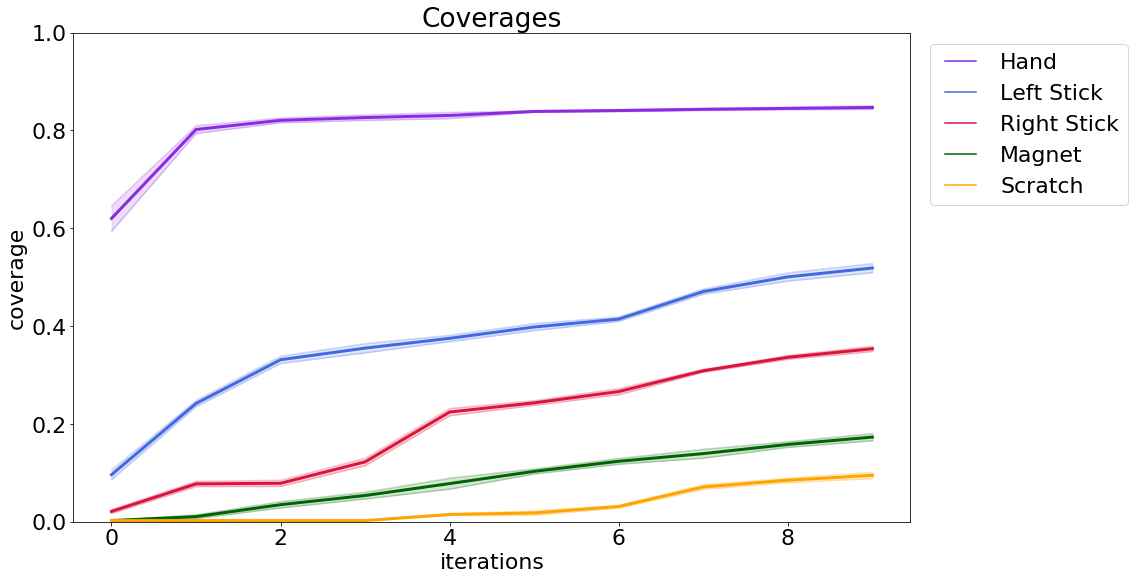

In [402]:
cov = coverage(subdirs,0, iterations=10, n_cpus=4)

In [239]:
plot_coverage(subdirs,0, iterations=10, n_cpus=4)

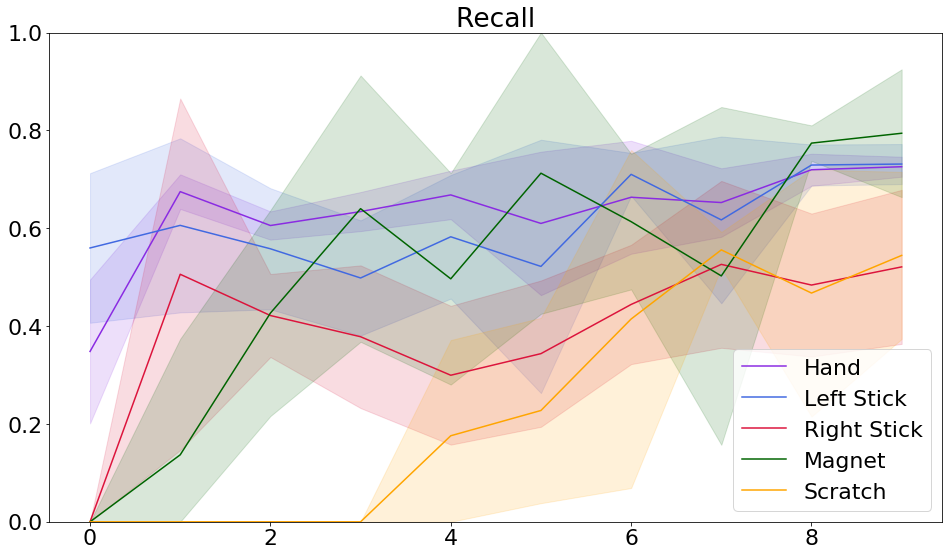

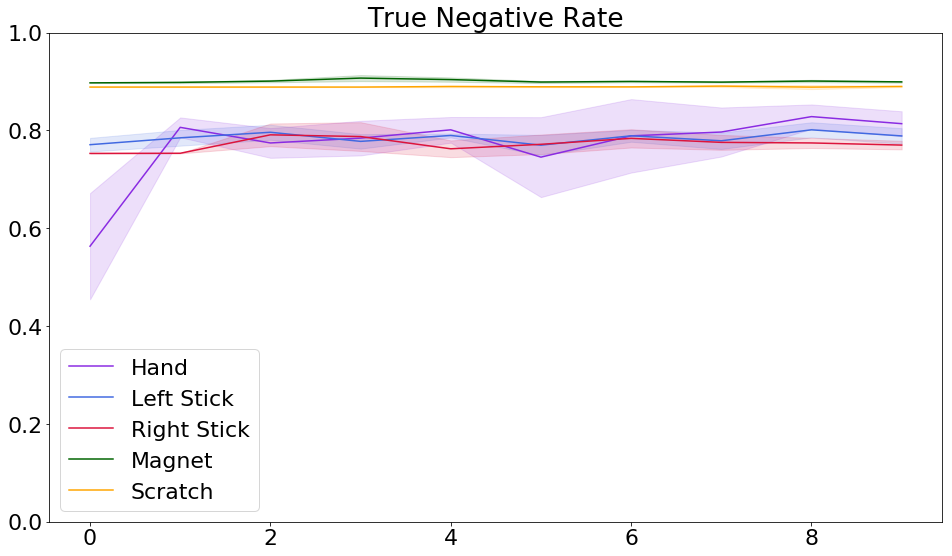

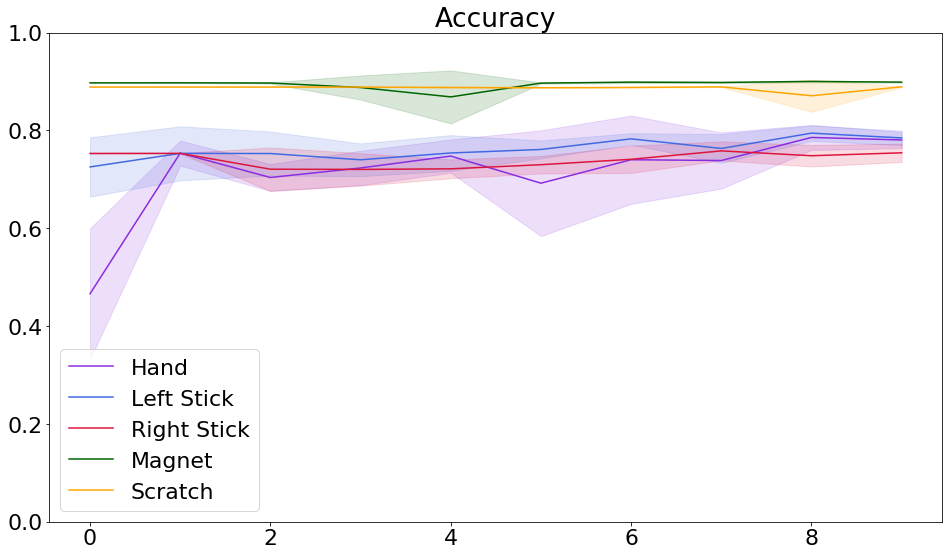

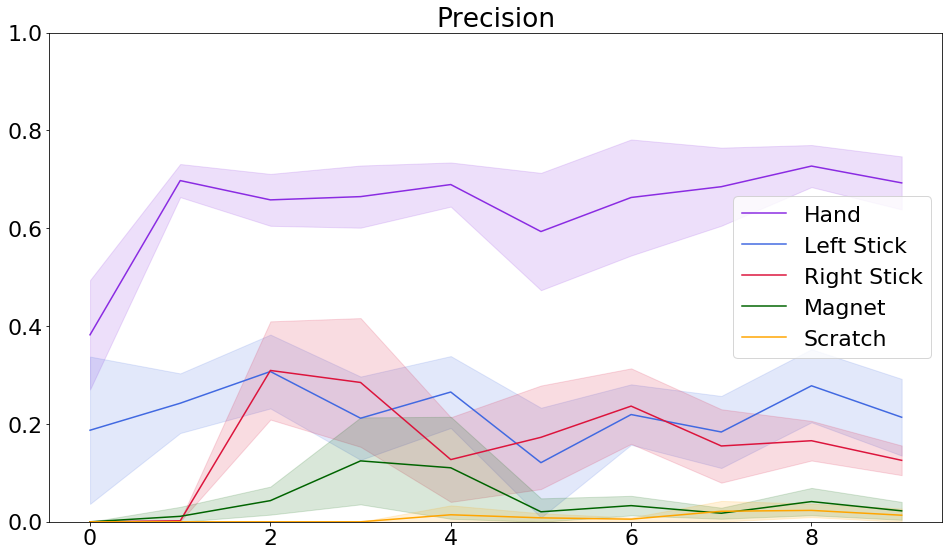

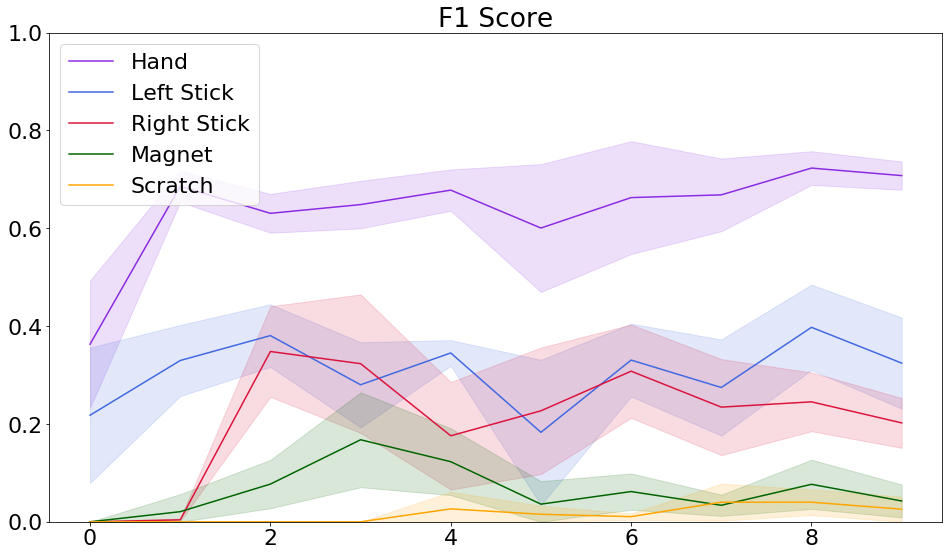

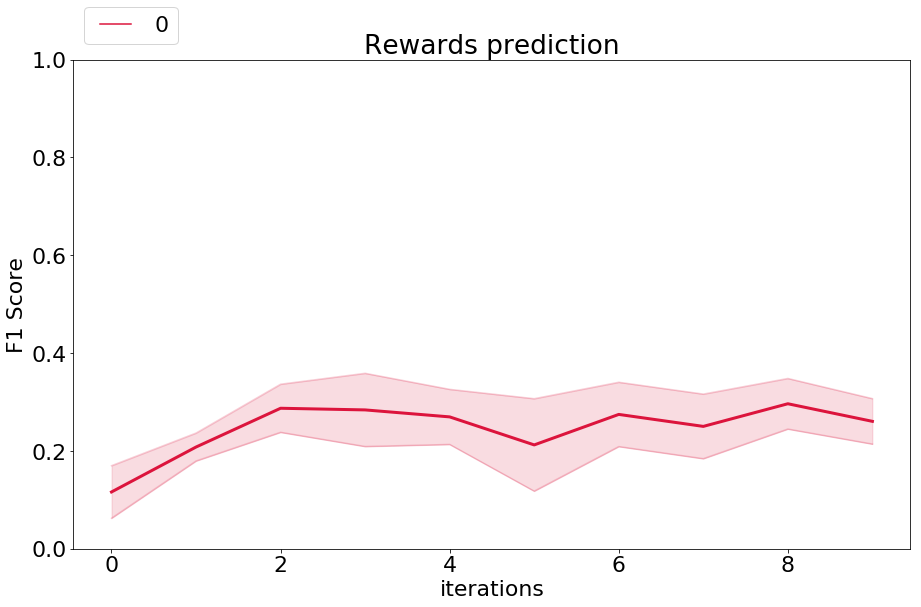

In [149]:
F1 = confusion_matrix(subdirs, data=1, iterations=10, n_cpus=4)

# Comparison params

In [589]:
def plot_objects(data, iterations, title, ylabel, minimum=0, maximum=np.inf, log =False):
    """ means [params, mean/std,  iterations, objects] """
    fig,ax = plt.subplots(5,1, sharex=True,figsize=(16,35))

    X = range(iterations)
    objects = ['Hand', 'Left Stick','Right Stick', 'Magnet', 'Scratch']
    group_legend = [  obj+" "+ title for obj in objects]
    colors = ['royalblue','crimson','darkgreen','orange','blueviolet']
    style = ['-','--',':',';']

    for obj in range(5):
        plt.subplot(511+obj)
        for i in range(len(data)):
            mean = data[i,0]
            std = data[i,1]
            color = colors[i]

            mean_p_std = np.minimum(mean[:,obj]+std[:,obj], maximum)
            mean_m_std = np.maximum(mean[:,obj]-std[:,obj], minimum)
            plt.plot(mean[:,obj], c=color, label=names[i])
            plt.fill_between(X, mean_p_std, mean_m_std, color=color, alpha=0.15)
            plt.title(group_legend[obj])
            plt.legend()
            if log:
                plt.yscale('log')
            if maximum == 1:
                plt.ylim((0,1))
            plt.ylabel(ylabel)

In [572]:
models_4 = "/home/tim/Documents/stage-m2/multi-task-her-rl/src/data/ArmToolsToys-v1/third"
models_20 = "/home/tim/Documents/stage-m2/multi-task-her-rl/src/data/from_remote/test_armToolsToys_full"

subdirs = [[models_4], [models_20]]
data = [1,1]
n_cpus = [4,20]
names =["4*2000","20*500"]

In [593]:
iterations = 10 
pred = []
F1 = []
coverage = []
for param,data_type,cpus in zip(subdirs,data,n_cpus):
    F1.append(confusion_matrix(param, data_type=data_type, iterations=iterations, n_cpus=cpus, plot=False))
    coverage.append(compute_coverage(param, data_type=data_type, iterations=iterations, n_cpus=cpus, plot=False))
    pred.append(prediction_errors(param,np.mean,data_type=data_type, iterations=iterations, n_cpus=cpus, plot=False))
F1 = np.array(F1)
coverage = np.array(coverage)
pred = np.swapaxes(np.swapaxes(np.swapaxes(pred, 4,5), 3,5), 2,3)

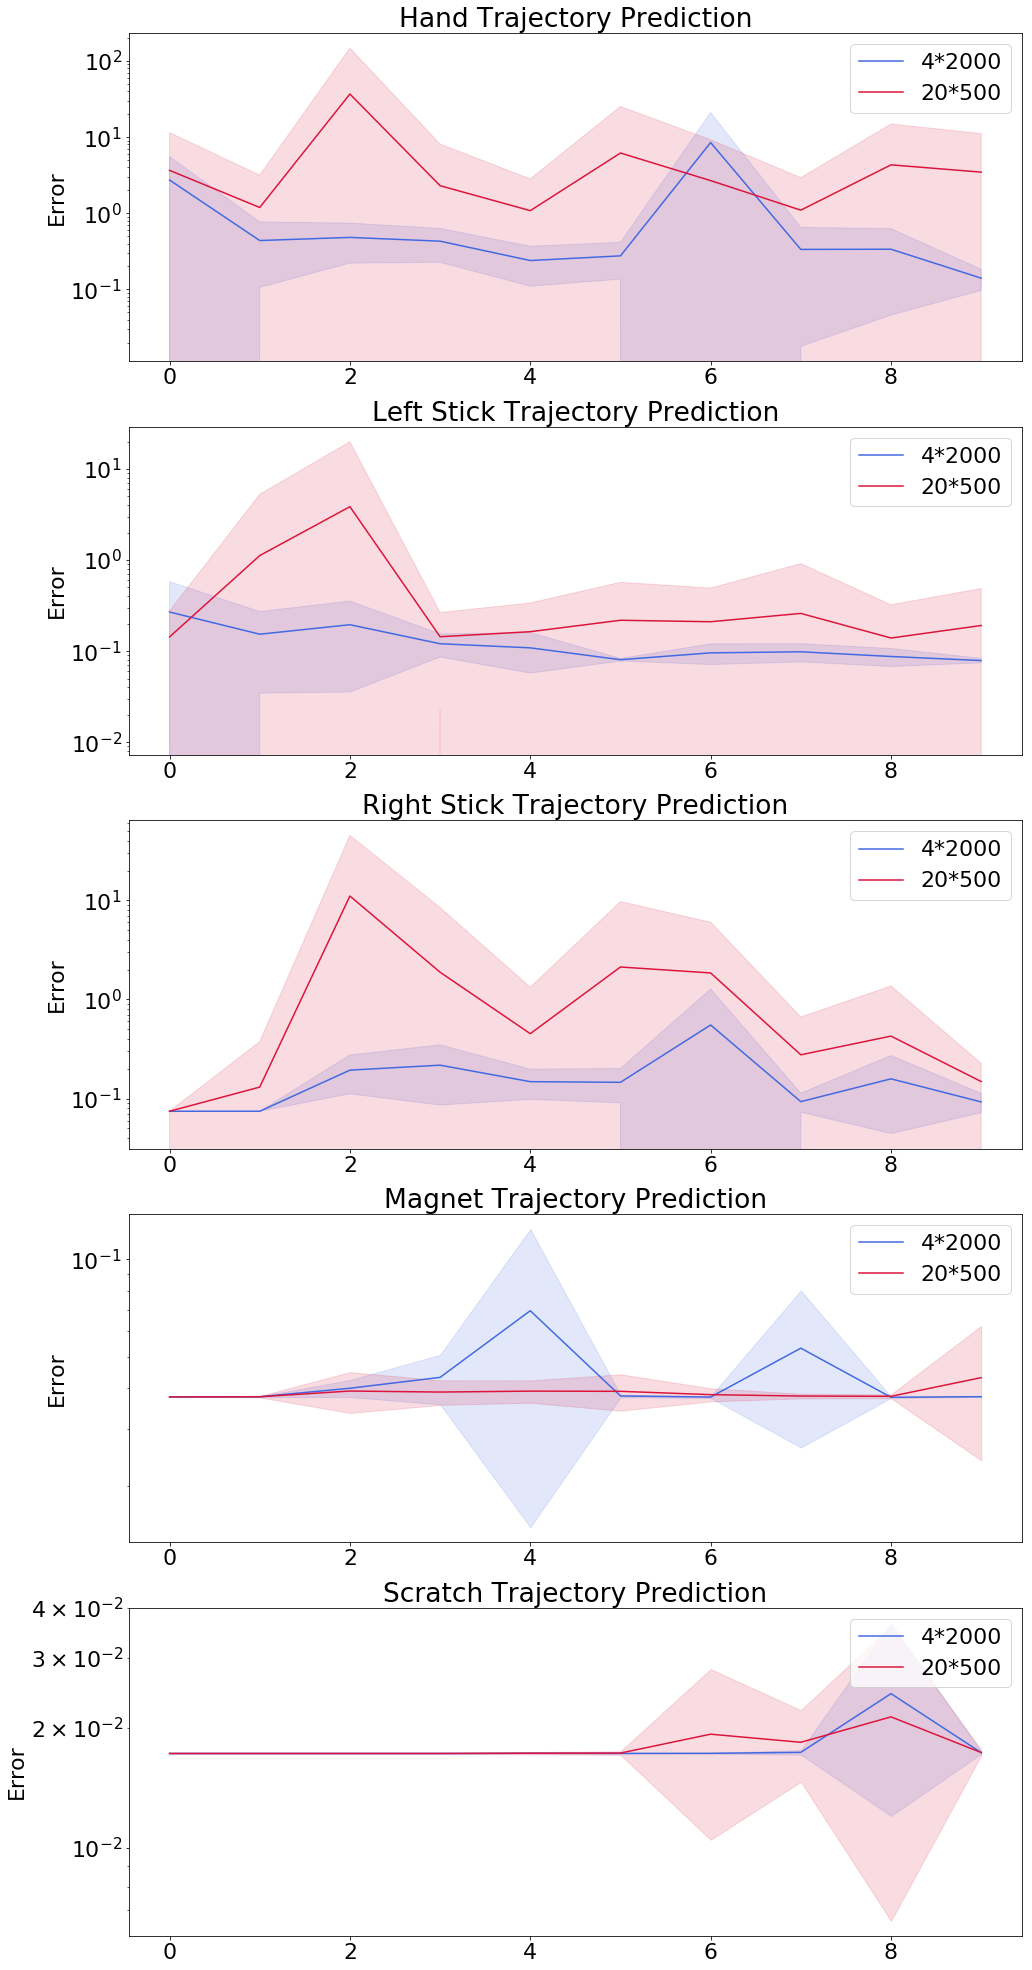

In [594]:
plot_objects(pred[:,0,0], iterations=10, title="Trajectory Prediction", ylabel="Error", log=True)

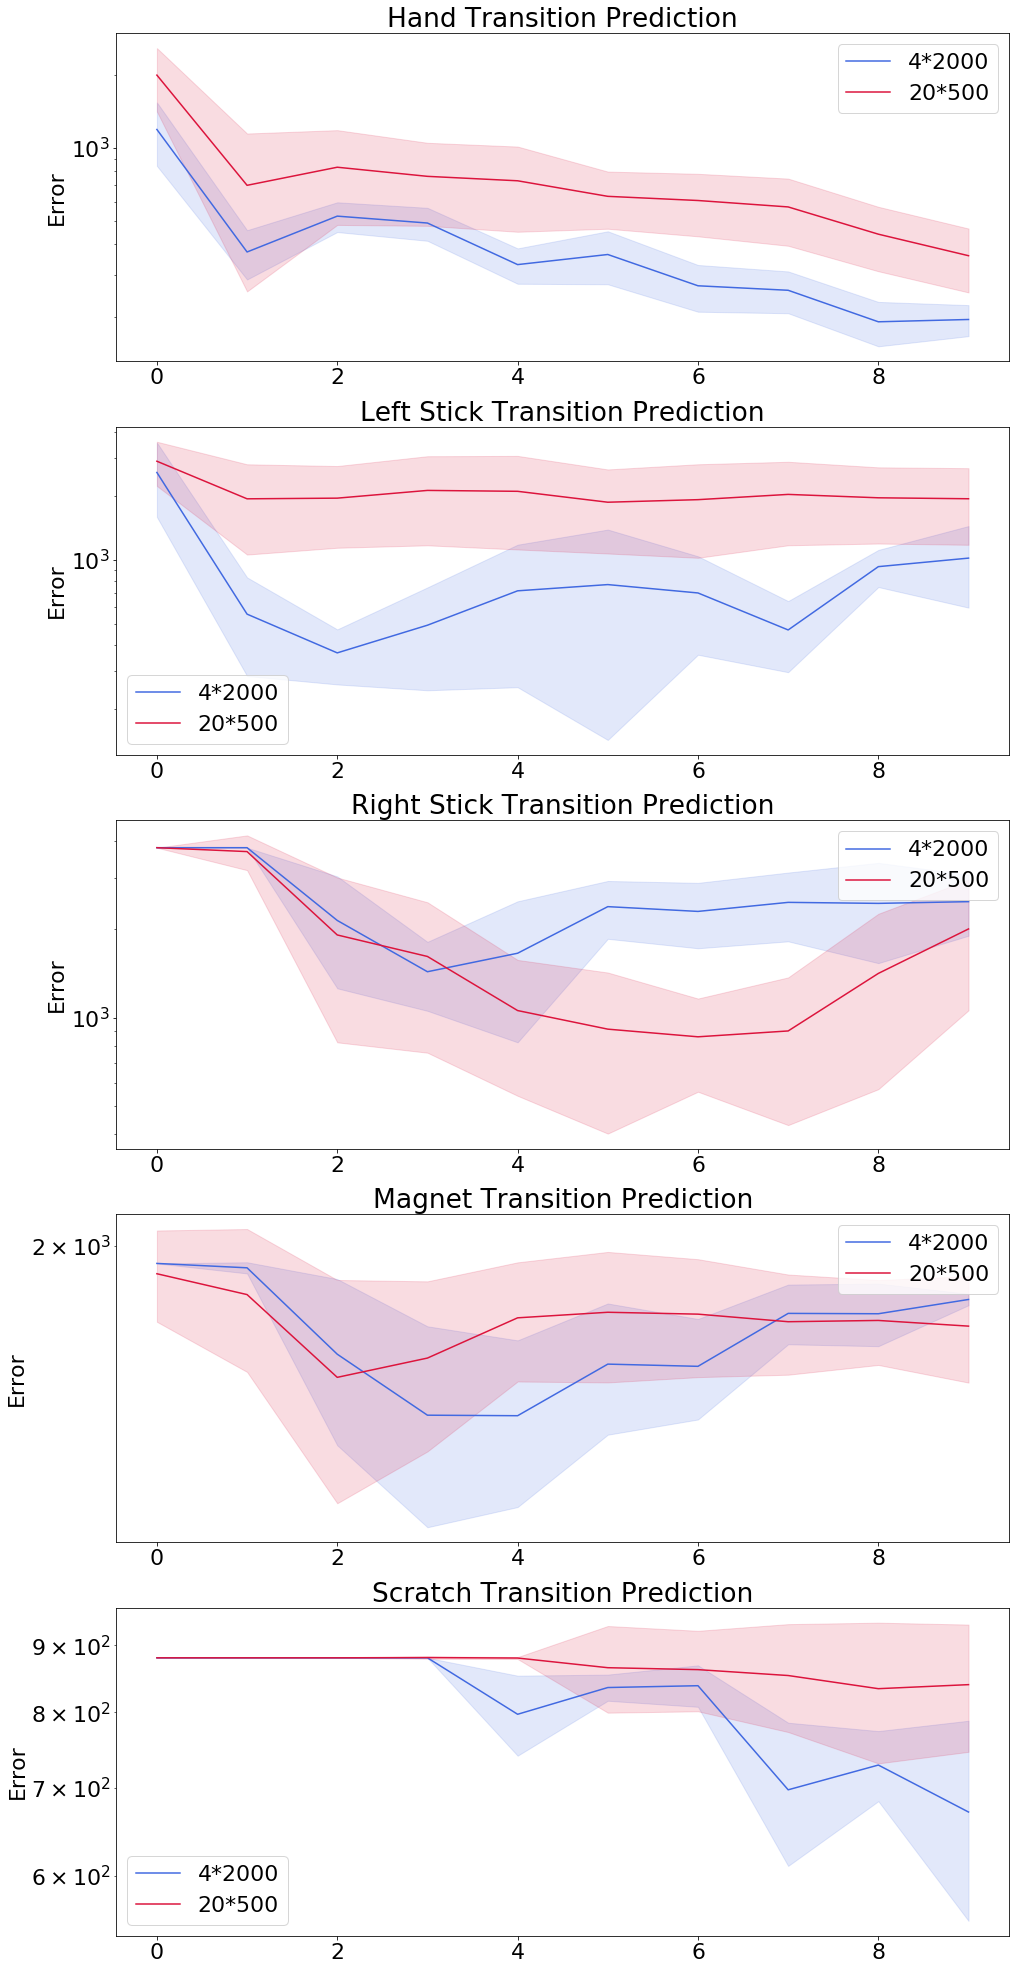

In [591]:
plot_objects(pred[:,0,1], iterations=10, title="Transition Prediction", ylabel="Error", log = True)

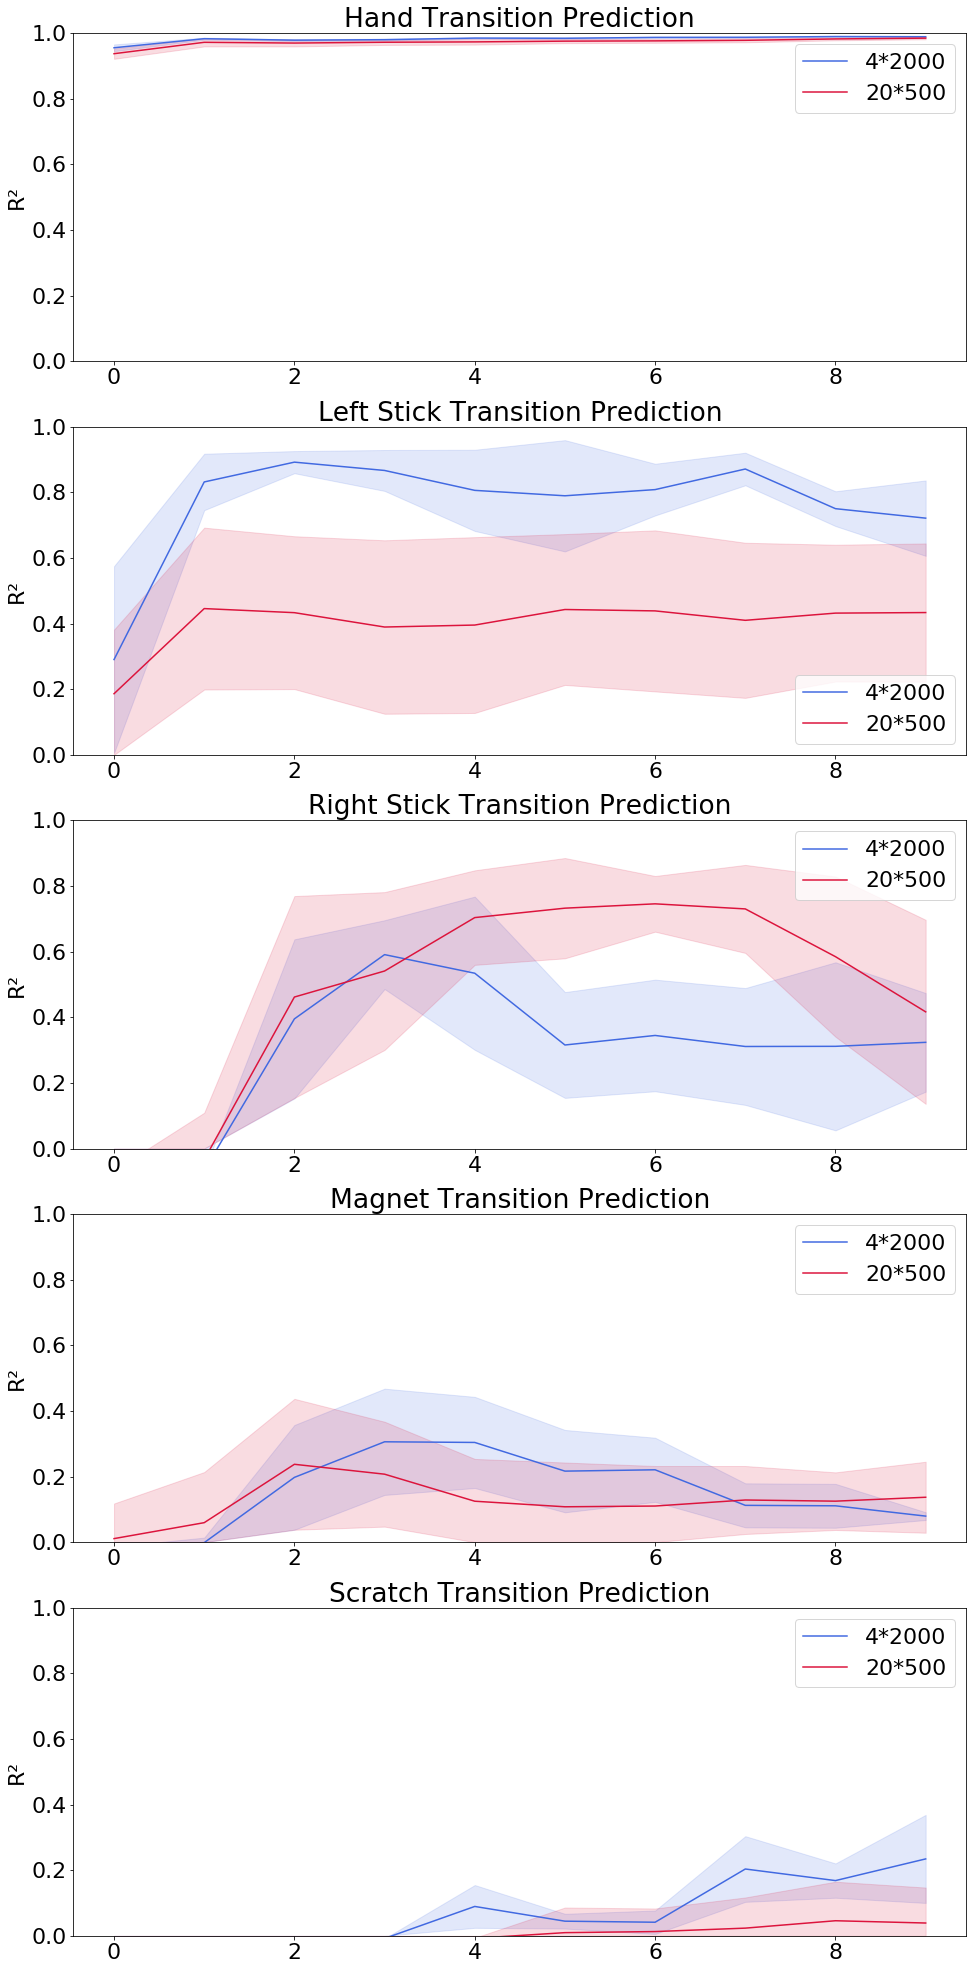

In [578]:
plot_objects(pred[:,1,1], iterations=10, title="Transition Prediction", ylabel="R²", minimum=0, maximum=1)

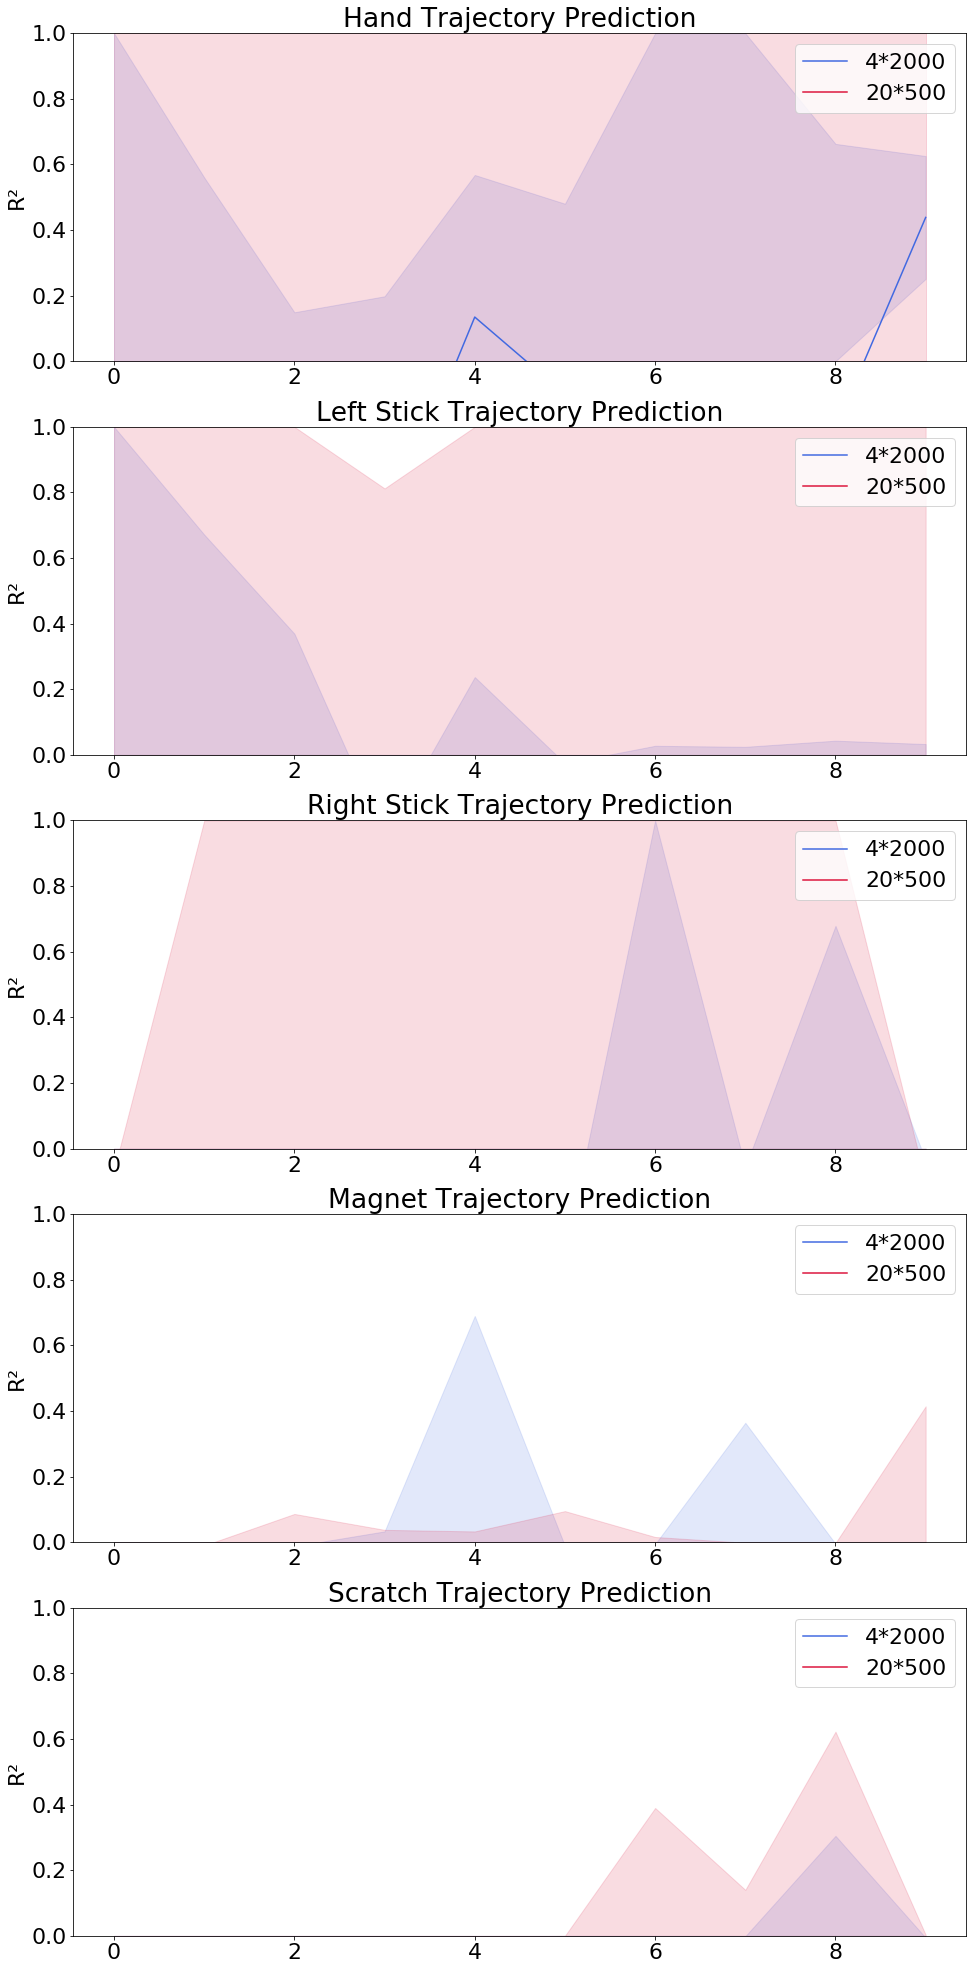

In [577]:
plot_objects(pred[:,1,0], iterations=10, title="Trajectory Prediction", ylabel="R²", minimum=0, maximum=1)

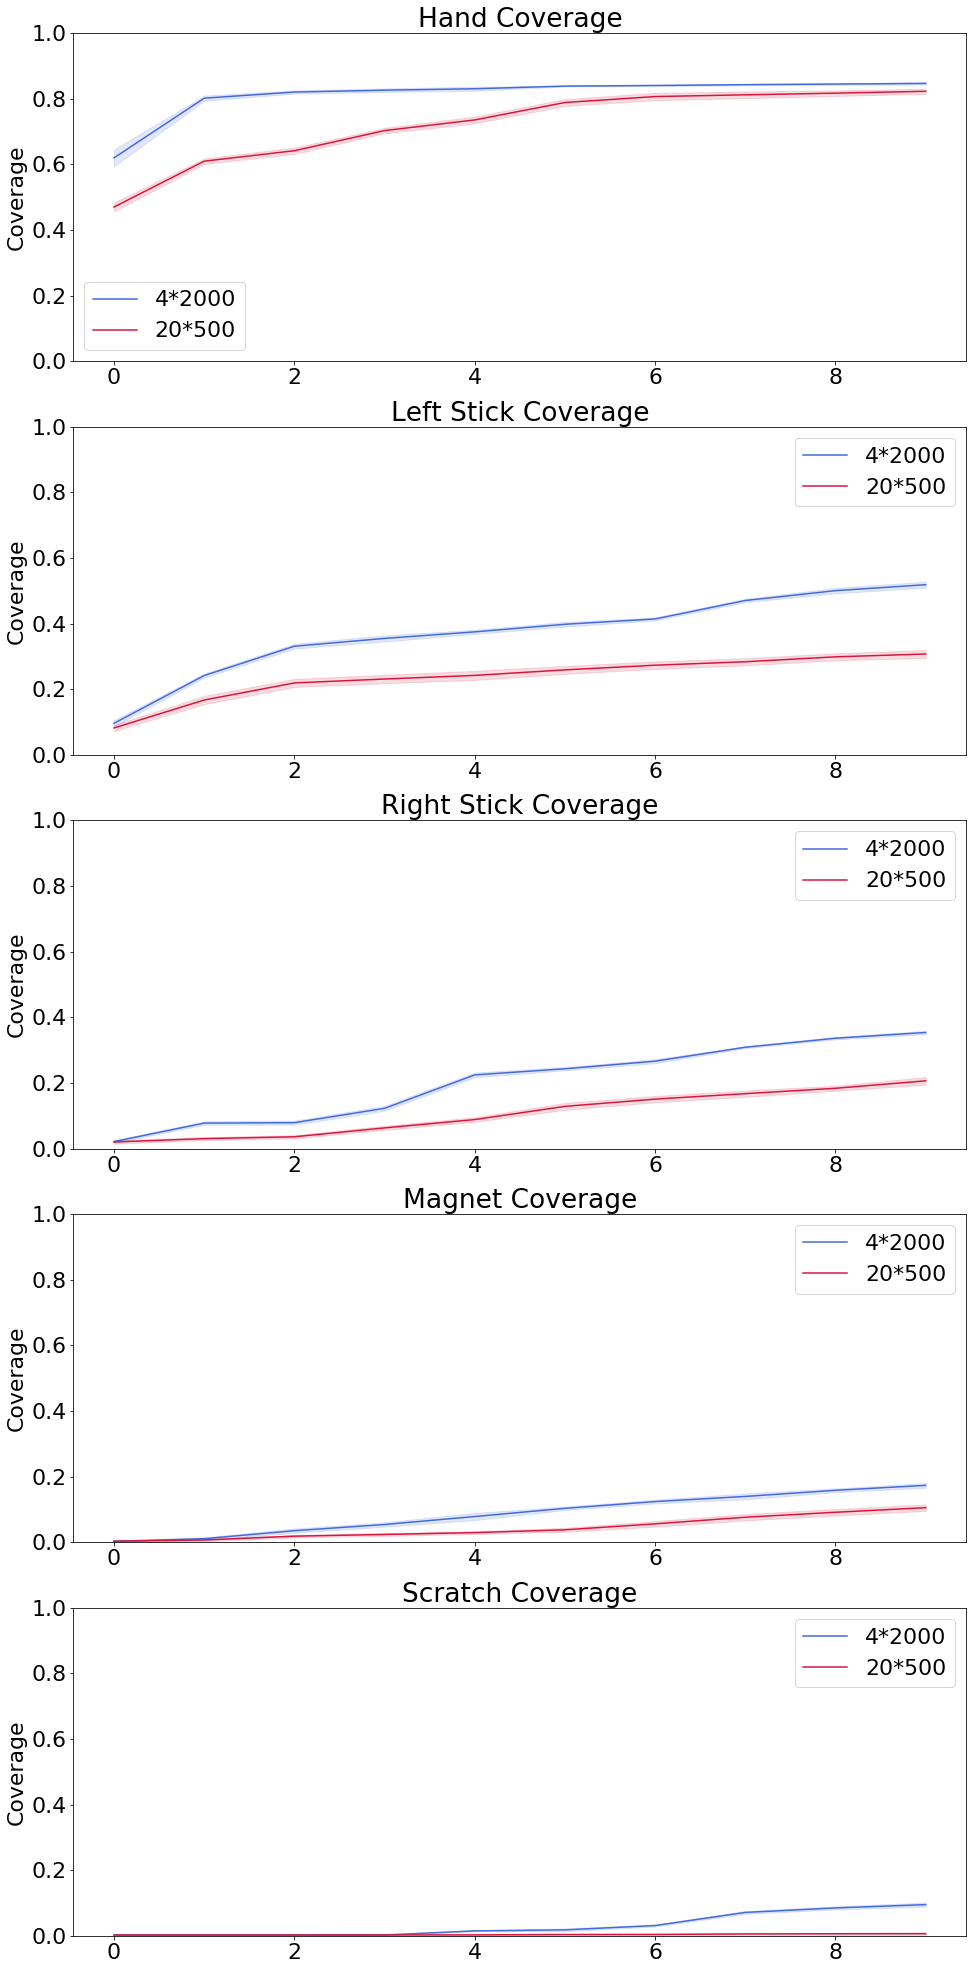

In [500]:
plot_objects(coverage, iterations=10, title="Coverage", ylabel="Coverage", minimum=0, maximum=1)

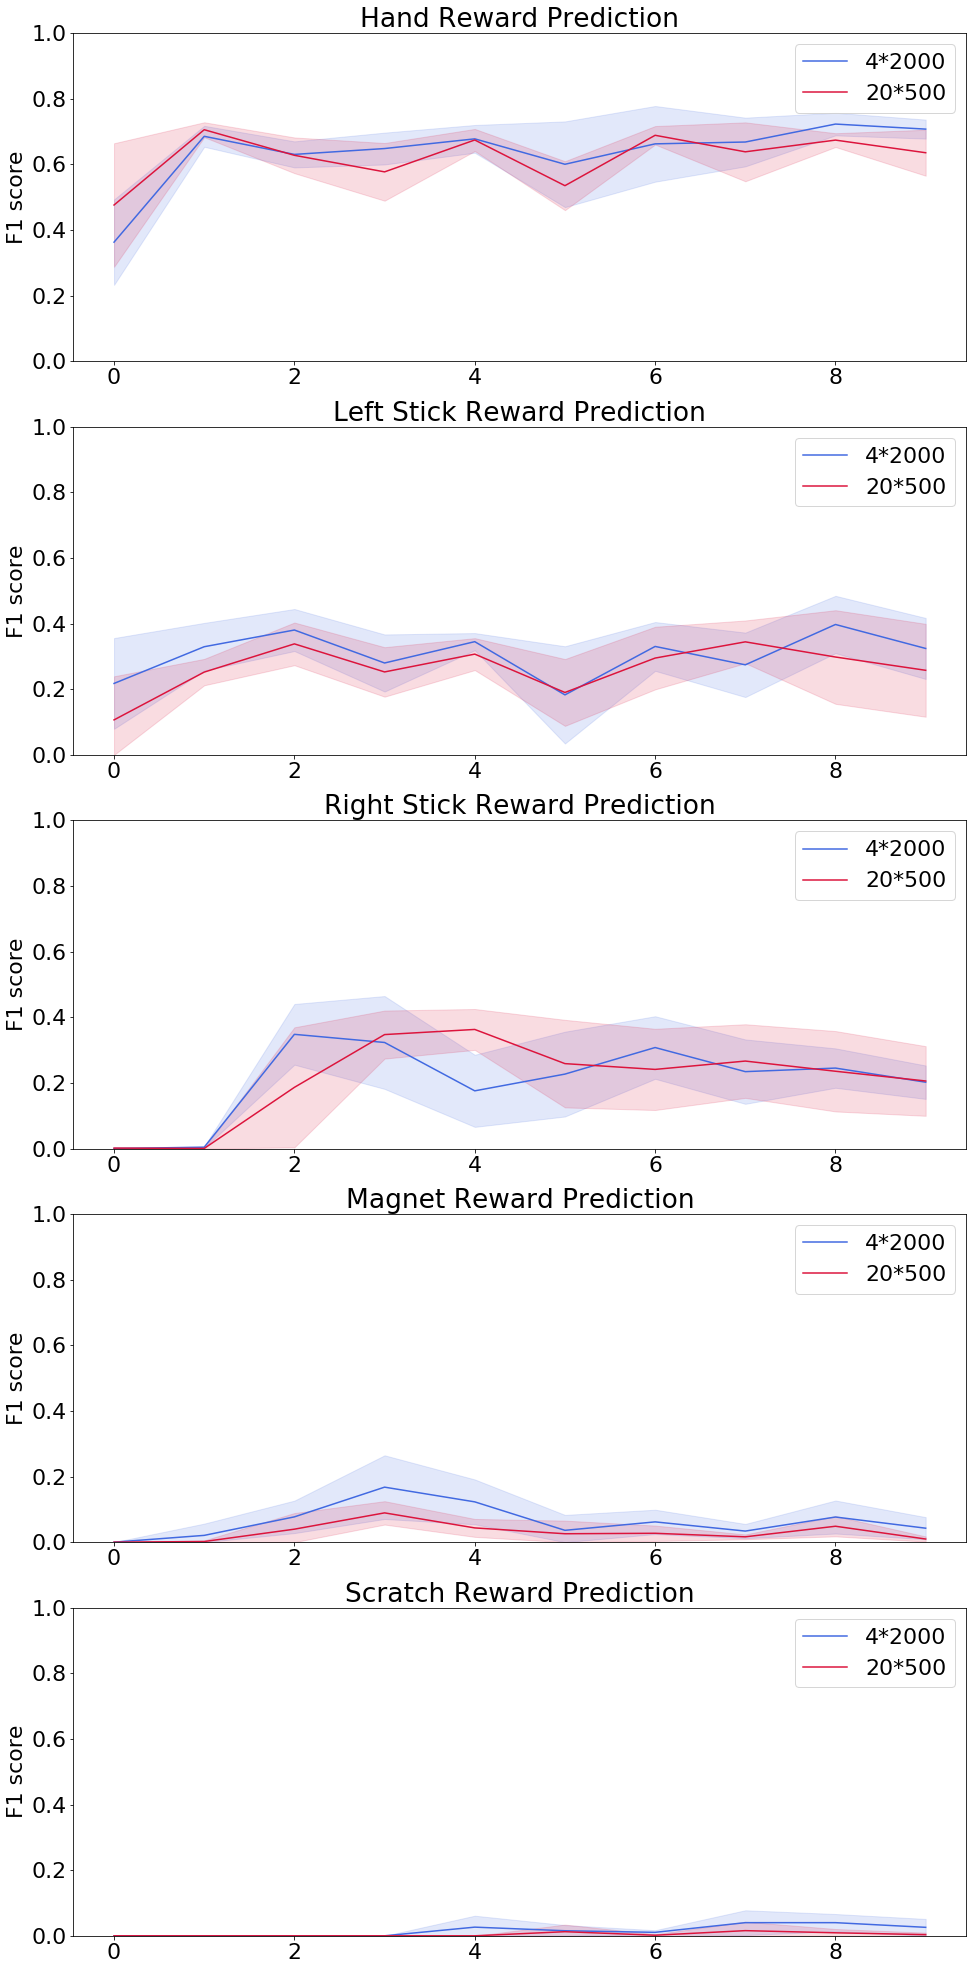

In [483]:
plot_objects(F1, iterations=10, title="Reward Prediction", ylabel="F1 score", minimum=0, maximum=1)